<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-soyoungcareer/blob/main/week4/Chapter3_1_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- 과제 수행순서
    1. `fancyzhx/ag_news` 로 dataset 변경
    2. tokenizer Truncation 제거 → 뉴스 기사이므로
    3. AG News 데이터셋 라벨 개수 확인
        
        ```python
        num_labels = len(ag_news['train'].unique('label'))
        print(f"Number of labels: {num_labels}")
        ```
        
    4. Google Drive mount
        
        ```python
        from google.colab import drive
        drive.mount('/content/drive')
        model_path = '/content/drive/MyDrive/hf_transformer'
        
        training_args = TrainingArguments(
            output_dir=model_path,  # 모델, log 등을 저장할 directory
            ...
        )
        ```
        
    5. hyper-parameter 수정
    6. dropout 추가

# HuggingFace로 영화리뷰 감정 분석 모델 구현하기

이번 실습에서는 HuggingFace로 영화리뷰 감정 분석과 같은 text 분류 문제를 위한 모델을 구현합니다.
먼저 필요한 library들을 설치하고 import합니다.

In [ ]:
!pip install -q transformers datasets evaluate accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 47.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
import random
import evaluate
import numpy as np

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

## Dataset 준비

그 다음 감정 분석을 위해 사용할 imdb dataset을 `load_dataset` 함수로 다운로드 받습니다.

In [ ]:
ag_news = load_dataset("fancyzhx/ag_news")    # dataset 변경
ag_news

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

`load_dataset`은 HuggingFace의 `datasets` library의 함수로, HuggingFace의 hub에서 dataset을 다운로드 받을 수 있도록 만든 함수입니다.
출력 결과를 보시면 `imdb`는 `train`, `test`, 그리고 `unsupervised` data로 구성되어있습니다.
이 중에서 우리는 `train`과 `test`를 활용합니다.

`train` data를 한 번 살펴보겠습니다.

In [ ]:
ag_news['train'][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

`train`과 `test`의 각 data는 `text`와 `label`로 구성되어있습니다.
각각은 영화리뷰와 해당 영화리뷰의 긍정/부정 여부를 의미합니다.
이는 이전 주차들에서 사용한 imdb dataset과 동일합니다.

이번에는 tokenizer를 불러와서 미리 text들을 tokenize합니다.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def preprocess_function(data):
    return tokenizer(data["text"])    # 뉴스 기사이므로 Truncation 제거

ag_news_tokenized = ag_news.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Tokenizer를 실행할 때 넘겨주었던 `truncation` 옵션은 주어진 text가 일정 길이 이상이면 잘라내라는 의미입니다.
만약 특정 길이 값이 같이 주어지지 않는다면 `bert-base-cased`를 학습할 때 사용한 text의 최대 길이를 기준으로 값을 결정합니다.

In [ ]:
ag_news_tokenized['train'][0].keys()

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])

마지막 출력 결과를 보면, `text`와 `label` 이외에 `input_ids`가 생기신 것을 확인하실 수 있습니다.
이는 우리가 `AutoTokenizer.from_pretrained`로 불러온 tokenizer로 text를 token들로 나누고 정수 index로 변환한 결과입니다.

이번에는 `train` data를 쪼개 training data와 validation data를 만들어보겠습니다.

In [ ]:
# test split 은 학습에 사용하지 않음.
ag_news_split = ag_news_tokenized['train'].train_test_split(test_size=0.2)
ag_news_train, ag_news_val = ag_news_split['train'], ag_news_split['test']
ag_news_test = ag_news_tokenized['test']

HuggingFace `datasets`로 불러온 dataset은 `train_test_split`으로 쉽게 쪼갤 수 있습니다.

다음은 각 split의 크기입니다.

In [ ]:
len(ag_news_train), len(ag_news_val), len(ag_news_test)

(96000, 24000, 7600)

In [ ]:
# AG 뉴스 데이터셋에서 라벨 개수 확인 후 동적으로 설정
num_labels = len(ag_news['train'].unique('label'))
print(f"Number of labels: {num_labels}")

Number of labels: 4


## Model 구현

이번에는 text 분류를 수행할 Transformer를 구현합니다.
이전에는 Transformer의 구성 요소들을 직접 구현하여 합쳤습니다.
이번에는 HuggingFace의 BERT를 활용하여 인자만 넘겨주는 식으로 구현해보겠습니다:

In [ ]:
from transformers import BertConfig

config = BertConfig()

config.hidden_size = 128  # BERT layer의 기본 hidden dimension
config.intermediate_size = 128  # FFN layer의 중간 hidden dimension
config.num_hidden_layers = 4  # BERT layer의 개수
config.num_attention_heads = 8  # Multi-head attention에서 사용하는 head 개수
config.num_labels = num_labels  # 마지막에 예측해야 하는 분류 문제의 class 개수    -> AG News 분류 4 개

config.hidden_dropout_prob = 0.3
config.attention_probs_dropout_prob = 0.3

model = AutoModelForSequenceClassification.from_config(config)

BERT는 이전에 배운 Transformer의 architecture를 그대로 사용합니다.
그래서 BERT의 옵션들만 수정하면 vanilla Transformer를 쉽게 구현할 수 있습니다.

Transformer 구현 이외에 분류 문제에 맞춰 첫 번째 token을 linear classifier를 거치는 등의 과정은 `AutoModelForSequenceClassification`이 구현해줍니다.
즉, 우리가 `config`로 넘겨주는 BERT의 마지막에 linear classifier를 달아주는 역할을 합니다.

## 학습 코드

다음은 위에서 구현한 Transformer를 imdb로 학습하는 코드를 구현합니다.
먼저 다음과 같이 학습 인자들을 정의합니다.

In [ ]:
from transformers import TrainingArguments, Trainer

from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/hf_transformer'

training_args = TrainingArguments(
    output_dir=model_path,  # 모델, log 등을 저장할 directory
    num_train_epochs=20,  # epoch 수
    per_device_train_batch_size=64,  # training data의 batch size
    per_device_eval_batch_size=64,  # validation data의 batch size
    logging_strategy="epoch",  # Epoch가 끝날 때마다 training loss 등을 log하라는 의미
    do_train=True,  # 학습을 진행하겠다는 의미
    do_eval=True,  # 학습 중간에 validation data에 대한 평가를 수행하겠다는 의미
    eval_strategy="epoch",  # 매 epoch가 끝날 때마다 validation data에 대한 평가를 수행한다는 의미
    save_strategy="epoch",  # 매 epoch가 끝날 때마다 모델을 저장하겠다는 의미
    learning_rate=1e-5,  # optimizer에 사용할 learning rate
    load_best_model_at_end=True,  # 학습이 끝난 후, validation data에 대한 성능이 가장 좋은 모델을 채택하겠다는 의미
    weight_decay=0.01  # weight decay 적용
)

Mounted at /content/drive


각각의 부분들은 이전 주차에서 배웠던 내용들을 설정하는 것에 불과하다는 것을 알 수 있습니다.
요약하면 다음과 같습니다:
- `epochs`: training data를 몇 번 반복할 것인지 결정합니다.
- `batch_size`: training data를 얼마나 잘게 잘라서 학습할 것인지 결정합니다.
- `learning_rate`: optimizer의 learning rate를 얼마로 할 것인지 결정합니다.
위의 부분들 이외에도 사소한 구현 요소들도 지정할 수 있습니다.

다음은 loss 이외의 평가 함수들을 구현하는 방법입니다.

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")


def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

`evaluate` 또한 HuggingFace의 library로 다양한 평가 함수들을 제공하고 있습니다.
이번 실습의 경우, 감정 분석 문제는 분류 문제이기 때문에 정확도를 계산할 수 있습니다.
위와 같이 예측 결과(`pred`)와 실제 label(`labels`)가 주어졌을 때 정확도를 계산하는 것은 `evaluate`의 accuracy 함수로 구현할 수 있습니다.

마지막으로 위의 요소들을 종합하여 학습할 수 있는 `Trainer`를 구현합니다.

In [ ]:
from transformers import EarlyStoppingCallback


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ag_news_train,
    eval_dataset=ag_news_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
)

모델, training 인자, training과 validation data, 부가적인 평가 함수, 그리고 tokenizer를 넘겨주면 끝입니다.
별개로 early stopping과 같은 기능도 주석 친 부분과 같이 `callbacks`로 구현할 수 있으니 참고해주시길 바랍니다.

위와 같이 만든 `Trainer`는 다음과 같이 학습을 할 수 있습니다.

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.383700,1.341955,0.457833
2,1.026300,0.919758,0.552000
3,0.850600,0.741426,0.653875
4,0.712200,0.661825,0.676000
5,0.647300,0.607170,0.694625
6,0.573500,0.536342,0.798667
7,0.511600,0.459179,0.847292
8,0.439900,0.404476,0.869500
9,0.394300,0.380060,0.878042
10,0.368700,0.365098,0.883625


TrainOutput(global_step=30000, training_loss=0.5040906321207682, metrics={'train_runtime': 1106.8209, 'train_samples_per_second': 1734.698, 'train_steps_per_second': 27.105, 'total_flos': 728717012974080.0, 'train_loss': 0.5040906321207682, 'epoch': 20.0})

**(Train 1)**

    Epoch	Training Loss	Validation Loss	Accuracy
    1	0.399400	0.275137	0.907208
    2	0.206100	0.254291	0.911875
    3	0.140200	0.272582	0.913417
    4	0.099000	0.313133	0.912833
    5	0.066300	0.387221	0.912667

=> Validation Loss 가 점점 커져 멈춘 것으로 보임


**(Train 2)**


    Epoch	Training Loss	Validation Loss	Accuracy
    1	0.375300	0.265613	0.912833
    2	0.201300	0.277250	0.907917
    3	0.144300	0.284804	0.914375

=> Batch_size 를 64 -> 32로 줄였으나, Validation Loss는 증가함.

**(Train 3)**

    Epoch	Training Loss	Validation Loss	Accuracy
    1	0.513000	0.288069	0.906083
    2	0.231400	0.267488	0.912292
    3	0.173400	0.282251	0.912792
    4	0.136800	0.314334	0.912083
    5	0.110800	0.356683	0.909042
    TrainOutput(global_step=15000, training_loss=0.233097265625, metrics={'train_runtime': 354.543, 'train_samples_per_second': 2707.711, 'train_steps_per_second': 84.616, 'total_flos': 152954730120960.0, 'train_loss': 0.233097265625, 'epoch': 5.0})

=> learning Rate = 1e-3 -> 1e-4 로 조정하였으나, Validation Loss 증가.

**(Train 4)**

    Epoch	Training Loss	Validation Loss	Accuracy
    1	0.527000	0.309258	0.901083
    2	0.257000	0.289198	0.906875
    3	0.193800	0.294811	0.906583
    4	0.155600	0.313011	0.912167
    5	0.128100	0.337585	0.910250
    6	0.110000	0.370658	0.910333
    7	0.092900	0.403986	0.908375
    TrainOutput(global_step=21000, training_loss=0.20919134957449778, metrics={'train_runtime': 497.8709, 'train_samples_per_second': 1928.211, 'train_steps_per_second': 60.257, 'total_flos': 214047119566080.0, 'train_loss': 0.20919134957449778, 'epoch': 7.0})

=> early_stopping_patience = 3 -> 5 로 조정. weight_decay 추가. config 에 dropout = 0.2 추가. 마찬가지로 Validation Loss 증가


**(Train 5)**

    Epoch	Training Loss	Validation Loss	Accuracy
    1	1.384800	1.367745	0.506333
    2	1.032400	0.861712	0.579917
    3	0.818100	0.735056	0.670708
    4	0.690100	0.611808	0.722250
    5	0.588800	0.553608	0.759292
    6	0.545300	0.518315	0.802167
    7	0.509100	0.482504	0.834375
    8	0.478900	0.458732	0.845667
    9	0.458700	0.445890	0.854292
    10	0.448900	0.441842	0.856583
    TrainOutput(global_step=15000, training_loss=0.6955198608398437, metrics={'train_runtime': 508.5775, 'train_samples_per_second': 1887.618, 'train_steps_per_second': 29.494, 'total_flos': 363584376000000.0, 'train_loss': 0.6955198608398437, 'epoch': 10.0})

=> learning Rate = 1e-4 -> 1e-5 로 조정. dropout = 0.2 -> 0.3 으로 조정. batch_size = 32 -> 64 로 조정.

=> Validation Loss는 감소하고 있으나, Accuracy가 90%를 넘기지 못함.

**(Train 5 graph)**

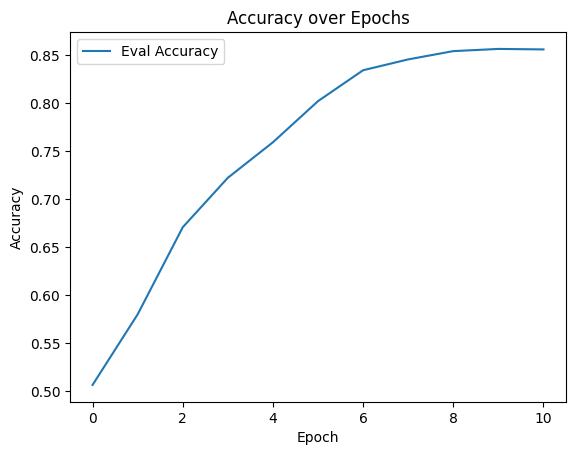

**(Train 6)**

    Epoch	Training Loss	Validation Loss	Accuracy
    1	1.383700	1.341955	0.457833
    2	1.026300	0.919758	0.552000
    3	0.850600	0.741426	0.653875
    4	0.712200	0.661825	0.676000
    5	0.647300	0.607170	0.694625
    6	0.573500	0.536342	0.798667
    7	0.511600	0.459179	0.847292
    8	0.439900	0.404476	0.869500
    9	0.394300	0.380060	0.878042
    10	0.368700	0.365098	0.883625
    11	0.350900	0.353309	0.888000
    12	0.337800	0.347263	0.890625
    13	0.328300	0.341058	0.892167
    14	0.321600	0.337939	0.893583
    15	0.315400	0.334612	0.895042
    16	0.309200	0.332410	0.895708
    17	0.305300	0.332498	0.895875
    18	0.303600	0.331653	0.895333
    19	0.301300	0.330347	0.896583
    20	0.300400	0.330338	0.896375
    TrainOutput(global_step=30000, training_loss=0.5040906321207682, metrics={'train_runtime': 1106.8209, 'train_samples_per_second': 1734.698, 'train_steps_per_second': 27.105, 'total_flos': 728717012974080.0, 'train_loss': 0.5040906321207682, 'epoch': 20.0})

=> epoch = 10 -> 20 으로 조정.

=> Train 5 와 마찬가지로 Validation Loss는 감소하고 있으나, Accuracy가 90%를 넘기지 못함.

보시다시피 training loss는 잘 떨어지는 반면, validation loss는 중간부터 쭉 올라가는 것을 볼 수 있습니다.
Overfitting이 일어났다고 볼 수 있습니다.

위와 같이 학습이 끝난 후 validation loss가 가장 낮은 모델을 가지고 test data의 성능을 평가하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
trainer.evaluate(ag_news_test)

{'eval_loss': 0.3489745855331421,
 'eval_accuracy': 0.8894736842105263,
 'eval_runtime': 1.8976,
 'eval_samples_per_second': 4005.001,
 'eval_steps_per_second': 62.71,
 'epoch': 20.0}

In [ ]:
trainer.state.log_history

[{'loss': 1.3837,
  'grad_norm': 0.6269806027412415,
  'learning_rate': 9.5e-06,
  'epoch': 1.0,
  'step': 1500},
 {'eval_loss': 1.3419549465179443,
  'eval_accuracy': 0.4578333333333333,
  'eval_runtime': 6.3982,
  'eval_samples_per_second': 3751.042,
  'eval_steps_per_second': 58.61,
  'epoch': 1.0,
  'step': 1500},
 {'loss': 1.0263,
  'grad_norm': 1.808940052986145,
  'learning_rate': 9e-06,
  'epoch': 2.0,
  'step': 3000},
 {'eval_loss': 0.9197576642036438,
  'eval_accuracy': 0.552,
  'eval_runtime': 6.3029,
  'eval_samples_per_second': 3807.746,
  'eval_steps_per_second': 59.496,
  'epoch': 2.0,
  'step': 3000},
 {'loss': 0.8506,
  'grad_norm': 5.5728254318237305,
  'learning_rate': 8.5e-06,
  'epoch': 3.0,
  'step': 4500},
 {'eval_loss': 0.7414258718490601,
  'eval_accuracy': 0.653875,
  'eval_runtime': 6.3436,
  'eval_samples_per_second': 3783.367,
  'eval_steps_per_second': 59.115,
  'epoch': 3.0,
  'step': 4500},
 {'loss': 0.7122,
  'grad_norm': 22.003360748291016,
  'learning

이전에 학습 인자에서 `load_best_model_at_end=True`를 넘겨줬기 때문에 `trainer`는 학습이 끝난 후, 기본적으로 validation loss가 가장 좋은 모델을 가지고 `evaluate`를 진행합니다.
실제로 결과를 보면 `eval_loss`가 가장 낮은 validation loss와 유사한 것을 볼 수 있습니다.

평가할 때 사용한 모델은 다음과 같이 저장할 수 있습니다.

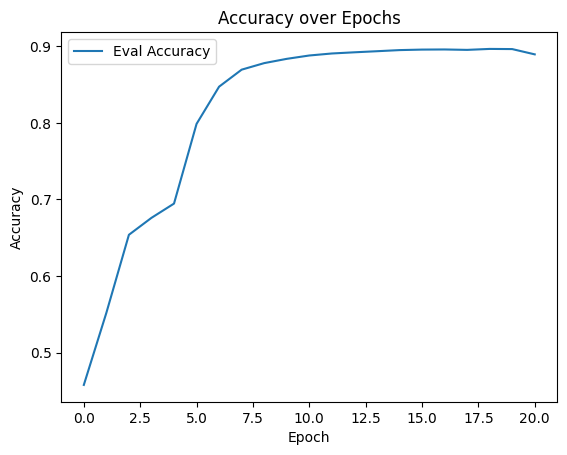

In [ ]:
import matplotlib.pyplot as plt

# Trainer 로그에서 accuracy 값 추출
def plot_accuracy(trainer):
    log_history = trainer.state.log_history

    # epoch마다 accuracy를 저장할 리스트
    eval_accuracy = []

    for entry in log_history:
        if 'eval_accuracy' in entry:
            eval_accuracy.append(entry['eval_accuracy'])

    # Plot 그리기
    plt.plot(eval_accuracy, label='Eval Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc="upper left")
    plt.title('Accuracy over Epochs')
    plt.show()

plot_accuracy(trainer)

In [ ]:
trainer.save_model()

그리고 저장한 모델을 가지고 다른 예시들을 예측하는 것은 다음과 같이 구현할 수 있습니다.

In [ ]:
from transformers import pipeline


classifier = pipeline("sentiment-analysis", model=model_path, device='cuda')
# print(classifier("The movie was so disgusting..."))
# print(classifier("The movie was so amazing!!"))
print(classifier("UK charges 8 in terror plot linked to alert in US LONDON, AUGUST 17: Britain charged eight terror suspects on Tuesday with conspiracy to commit murder and said one had plans that could be used in striking US buildings that were the focus of security scares this month."))

[{'label': 'LABEL_0', 'score': 0.9775611758232117}]


HuggingFace의 `pipeline`은 다양한 모델들에 대하여 서비스에 사용할 수 있는 형태들을 제공합니다.
여기서는 영화 리뷰가 주어졌을 때, label이 0(부정적인 리뷰)인지 1(긍정적인 리뷰)인지 예측 결과를 보여줄 뿐만 아니라 그 신뢰도를 `score`로 넘겨주게 됩니다.

이처럼 HuggingFace를 활용하면 모델이나 예측, 학습 코드를 구현할 필요 없이 인자로 설정값들만 넘겨주면 쉽게 구현 할 수 있습니다.